In [7]:
from langchain_community.document_loaders.csv_loader import CSVLoader
import pandas as pd
from IPython.display import Markdown
import re

from typing import Annotated, Literal
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.tools.retriever import create_retriever_tool
from langchain.document_loaders import PyMuPDFLoader, PyPDFLoader
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.tools import tool
from langchain_core.documents.base import Document
from langchain_core.vectorstores.base import VectorStoreRetriever
from langchain_core.output_parsers.openai_tools import JsonOutputToolsParser
from langchain_core.output_parsers.string import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda
from langchain_experimental.utilities import PythonREPL
from langchain_experimental.tools.python.tool import PythonAstREPLTool
from pydantic import BaseModel, Field
from markitdown import MarkItDown
import dotenv
import os

dotenv.load_dotenv()

True

In [8]:
file_path = "./data/athlete_events.csv"
# df = pd.read_csv(file_path)

llm = ChatOpenAI(model="gpt-4o-mini",
                 temperature=0.,)

In [9]:
class State(TypedDict):
    query : Annotated[str, "User Question"]
    answer : Annotated[str, "LLM Response"]
    df : Annotated[pd.DataFrame, "Dataset"]
    title : Annotated[str, "Dataset Title"]
    summary : Annotated[str, "Dataset Summary"]
    tool : Annotated[PythonAstREPLTool, "Code Execute Tool"]

In [10]:
def create_title_summary(df, file_path):
    text = f"""
            당신은 요약 전문가입니다.
           
            데이터셋 : {df}

            데이터셋의 정보를 보고 제목과 요약을 만들어냅니다.
            제목은 이 데이터셋을 가장 잘 표현할 수 있는 제목으로 결정하여야합니다.

            참고할 정보는 아래와 같습니다.

            파일 이름 : {file_path.split("/")[-1]}

            1. 제목: 
            2. 요약: 

            """
    
    result = llm.invoke(text).content

    title = "Untitled"
    summary = "No Summary"    

    try:
        lines = result.split("\n")
        title = lines[0].replace("1. 제목: ", "").strip()
        summary = "\n".join(lines[1:]).replace("2. 요약:", "").strip()
    except:
        pass

    return title, summary

In [12]:
def create_tools(df):
    tool = PythonAstREPLTool(name="python_repl_ast", 
                        description="A Python shell. Use this to execute python commands. \
                                    Input should be a valid python command. When using this tool, \
                                    sometimes output is abbreviated - make sure it does not look abbreviated before using it in your answer.",
                        locals={"df":df})
    
    return tool

In [13]:
def init_state(state:State):
    df = pd.read_csv(file_path)
    title, summary = create_title_summary(df, file_path)
    tool = create_tools(df)

    print("===== Init Complete =====")
    
    return {"df" : df,
            "title" : title,
            "summary" : summary,
            "tool" : tool}

In [14]:
def response_llm(state:State):
    
    prompt = PromptTemplate.from_template(
        f"""
        table : {state["df"]}

        당신은 데이터 분석 전문가입니다.
        주어진 table 데이터를 기반으로 데이터 분석에 도움을 주세요.

        query : {state["query"]}

        """
        )          
    
    return {"answer" : llm.invoke(prompt)}

In [15]:
class intersection(BaseModel):
    """
    당신은 도구의 실행을 결정하는 어시스턴트입니다.
    코드를 실행시켜야하는 경우라면 'tool' 이라고 답변하고 아닌 경우 'llm'라고 답변하세요.
    """

    binary_score : Literal["tool", "llm"] = Field(..., description="""You are the assistant in charge of determining the execution of the tool.
Answer 'tool' if you need to run the code and 'llm' if you don't.""")

In [19]:
graph_builder = StateGraph(State)

In [20]:
graph_builder.add_node("init state", init_state)
graph_builder.add_node("response", response_llm)

graph_builder.add_edge(START, "init state")
graph_builder.add_edge("init state", "response")
graph_builder.add_edge("response", END);

In [21]:
graph = graph_builder.compile()

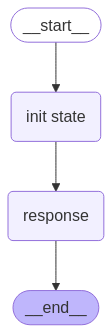

In [22]:
graph

In [23]:
result = graph.invoke({"query": "이건 무슨 데이터셋이야?"})

===== Init Complete =====


ValueError: Invalid input type <class 'langchain_core.prompts.prompt.PromptTemplate'>. Must be a PromptValue, str, or list of BaseMessages.

In [ ]:
result

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,135569,Andrzej ya,M,29.0,179.0,89.0,Poland-1,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,NaN
271112,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",NaN
271113,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",NaN
271114,135571,Tomasz Ireneusz ya,M,30.0,185.0,96.0,Poland,POL,1998 Winter,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,NaN
